In [1]:
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
import string
 
# load doc into memory
def load_doc(filename):
               # open the file as read only
               file = open(filename, mode='rt', encoding='utf-8')
               # read all text
               text = file.read()
               # close the file
               file.close()
               return text
def to_lines(doc):
    lines = doc.strip().split('\n')
    return lines
 
# split a loaded document into sentences
def to_pairs(doc):
               lines = doc.strip().split('\n')
               pairs = [line.split('\t') for line in  lines]
               return pairs
 
# clean a list of lines
def clean_pairs(lines):
   cleaned = list()
   # prepare regex for char filtering
   re_print = re.compile('[^%s]' % re.escape(string.printable))
   # prepare translation table for removing punctuation
   table = str.maketrans('', '', string.punctuation)
   for pair in lines:
      clean_pair = list()
      for line in pair:
         # normalize unicode characters
         line = normalize('NFD', line).encode('ascii', 'ignore')
         line = line.decode('UTF-8')
         # tokenize on white space
         line = line.split()
         # convert to lowercase
         line = [word.lower() for word in line]
         # remove punctuation from each token
         line = [word.translate(table) for word in line]
         # remove non-printable chars form each token
         line = [re_print.sub('', w) for w in line]
         # remove tokens with numbers in them
         line = [word for word in line if word.isalpha()]
         # store as string
         clean_pair.append(' '.join(line))
      cleaned.append(clean_pair)
   return array(cleaned)
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
               dump(sentences, open(filename, 'wb'))
               print('Saved: %s' % filename)
            
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
         

In [1]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

In [2]:
word_vectors = KeyedVectors.load_word2vec_format('Dataset/GoogleNews-vectors-negative300.bin', binary=True)

In [7]:
a=word_vectors['war']
word_vectors.most_similar(positive = [a])#[0][0]

[('war', 1.0),
 ('wars', 0.748465895652771),
 ('War', 0.6410670280456543),
 ('invasion', 0.5892110466957092),
 ('Persian_Gulf_War', 0.5890660285949707),
 ('Vietnam_War', 0.5886474847793579),
 ('Iraq', 0.588599443435669),
 ('unwinnable_quagmire', 0.5681803226470947),
 ('un_winnable', 0.560634970664978),
 ('occupation', 0.5506216287612915)]

In [ ]:
word_vectors.most_similar(positive = [a])

In [3]:
import numpy as np
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle
import tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt

import nltk
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model

Using TensorFlow backend.


In [5]:
# load dataset
filename = 'dev_en.txt'
doc_in = load_doc(filename)
filename = 'dev_sen.txt'
doc_out = load_doc(filename)
lines_in = to_lines(doc_in)
lines_out = to_lines(doc_out)

In [6]:
lines_in = np.asarray(lines_in)
lines_out = np.asarray(lines_out)

pairs = np.column_stack((lines_out, lines_in))
pairs = pairs.tolist()

In [7]:
pairs[2]
#type(pairs)

['Marin, Mendocino, Lake, Napa, Solano and Contra Costa are all adjacent countries.',
 'Adjacent counties are Marin ( to the south ) , Mendocino ( to the north ) , Lake ( northeast ) , Napa ( to the east ) , and Solano and Contra Costa ( to the southeast ) .']

In [8]:
# clean sentences
clean_pairs = clean_pairs(pairs[:200])
# save clean pairs to file
save_clean_data(clean_pairs, 'SimpleEnglish-English.pkl')
# spot check
#for i in range(100):
  # print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: SimpleEnglish-English.pkl


In [9]:
# load dataset
raw_dataset = load_clean_sentences('SimpleEnglish-English.pkl')
 
# reduce dataset size
n_sentences = 200
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test 
train, val, test = dataset[:150], dataset[150:170], dataset[170:] #Added Validation set - avs
# save
save_clean_data(dataset, 'SimpleEnglish-English-both.pkl')
save_clean_data(train, 'SimpleEnglish-English-train.pkl')
save_clean_data(val, 'SimpleEnglish-English-val.pkl')
save_clean_data(test, 'SimpleEnglish-English-test.pkl')


Saved: SimpleEnglish-English-both.pkl
Saved: SimpleEnglish-English-train.pkl
Saved: SimpleEnglish-English-val.pkl
Saved: SimpleEnglish-English-test.pkl


In [7]:
# load datasets
dataset = load_clean_sentences('SimpleEnglish-English-both.pkl')
train = load_clean_sentences('SimpleEnglish-English-train.pkl')
val = load_clean_sentences('SimpleEnglish-English-val.pkl') #added clean for val - avs
test = load_clean_sentences('SimpleEnglish-English-test.pkl')

In [10]:
# prepare SimpleEng tokenizer
sen_tokenizer = create_tokenizer(dataset[:, 0])
sen_vocab_size = len(sen_tokenizer.word_index) + 1
sen_length = max_length(dataset[:, 0])
print('SimpleEng Vocabulary Size: %d' % sen_vocab_size)
print('SimpleEng Max Length: %d' % (sen_length))

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 1])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 1])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

SimpleEng Vocabulary Size: 517
SimpleEng Max Length: 44
English Vocabulary Size: 288
English Max Length: 35


In [13]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 1])
trainY = encode_sequences(sen_tokenizer, sen_length, train[:, 0])
trainY = encode_output(trainY, sen_vocab_size)
# prepare validation data
valX = encode_sequences(eng_tokenizer, eng_length, val[:, 1]) #added tokeniser for val set - avs
valY = encode_sequences(sen_tokenizer, sen_length, val[:, 0])
valY = encode_output(valY, sen_vocab_size)
# prepare test data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 1])
testY = encode_sequences(sen_tokenizer, sen_length, test[:, 0])
testY = encode_output(testY, sen_vocab_size)

In [50]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed, Dense, Dropout


# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    model.add(Dropout(0.3))
    return model
 
# define model
model = define_model(eng_vocab_size, sen_vocab_size, eng_length, sen_length, 256)
model.compile(optimizer='adamax', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
#plot_model(model, to_file='model.png', show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 35, 256)           73728     
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 44, 256)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 44, 256)           525312    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 44, 517)           132869    
_________________________________________________________________
dropout_5 (Dropout)          (None, 44, 517)           0         
Total params: 1,257,221
Trainable params: 1,257,221
Non-trainable params: 0
____________________________________________

In [51]:
from keras.callbacks import ModelCheckpoint
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=15, batch_size=64, validation_data=(valX, valY), callbacks=[checkpoint], verbose=2)

Train on 150 samples, validate on 20 samples
Epoch 1/15


KeyboardInterrupt: 

dict_keys(['val_loss', 'loss'])


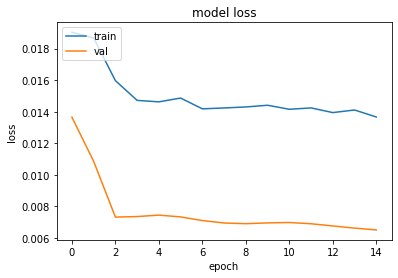

In [37]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [38]:

# load model
model = load_model('model.h5')

In [39]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [40]:

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, sen_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [41]:
evaluate_model(model,sen_tokenizer,trainX,train)

src=[many of the churches work together for townwide projects under the banner of churches together in stevenage], target=[many of the churches work together for townwide projects calliing themselves churches together in stevenage], predicted=[]
src=[tracking northwestward the depression moved ashore near fort walton beach early on september and shortly thereafter it dissipated over southeastern alabama], target=[tracking northwestward the depression moved ashore near fort walton beach early on september and shortly thereafter it fell apart over southeastern alabama], predicted=[]
src=[in return romania ceded three southern districts of bessarabia to russia and acquired dobruja], target=[romania ceded three southern districts of bessarabia to russia in return for dorbuja], predicted=[]
src=[in march the world wrestling federation purchased world championship wrestling], target=[in march the world wrestling federation bought world championship wrestling], predicted=[]
src=[the empire of